# Baseball Data: a thorough analysis 
#### A data set containing complete batting and pitching statistics from 1871 to 2014, plus fielding statistics, standings, team stats, managerial records, post-season data, and more. 

#### the data is available at: http://www.seanlahman.com/baseball-archive/statistics/

### Focus of our analysis
#### Our analysis will focus on players salaries:
- What is the salary evolution?
- Were different teams awarded different salaries?
    - were the difference justified?
- Did awarded players earn more on average?
- What was the influence of appearances on salary?
- Did the college attended influence salary of players?
- Were the players with the best statistics awarded the with the best salaries?

### Packages needed

In [1]:
# Import General Packages
import numpy as np
import pandas as pd

# Import plotting/graphics packages
import matplotlib.pyplot as plt
import seaborn as sns 

# Graphics inline 
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Importing the datasets of interest 

Main tables:
- MASTER - Player names, DOB, and biographical info
- Batting - batting statistics
- Pitching - pitching statistics
- Fielding - fielding statistics


Supplemented by theses tables 
- Teams - yearly stats and standings 
- Salaries - player salary data
- AwardsPlayers - awards won by players
- AwardsSharePlayers - award voting for player awards
- Appearances - details on the positions a player appeared at
- Schools - list of colleges that players attended
- CollegePlaying - list of players and the colleges they attended

In [132]:
master = pd.read_csv('baseballdatabank-2017.1/core/Master.csv')
batting = pd.read_csv('baseballdatabank-2017.1/core/Batting.csv')
pitching = pd.read_csv('baseballdatabank-2017.1/core/Pitching.csv')
fielding = pd.read_csv('baseballdatabank-2017.1/core/Fielding.csv')
teams = pd.read_csv('baseballdatabank-2017.1/core/Teams.csv')
salaries = pd.read_csv('baseballdatabank-2017.1/core/Salaries.csv')
awardPlayers = pd.read_csv('baseballdatabank-2017.1/core/AwardsPlayers.csv')
awardsSharePlayers = pd.read_csv('baseballdatabank-2017.1/core/AwardsSharePlayers.csv')
appearances = pd.read_csv('baseballdatabank-2017.1/core/Appearances.csv')
schools = pd.read_csv('baseballdatabank-2017.1/core/Schools.csv')
collegePlaying = pd.read_csv('baseballdatabank-2017.1/core/CollegePlaying.csv')
managers = pd.read_csv('baseballdatabank-2017.1/core/Managers.csv')

### External Data ###
#### Consumer Price Index from: https://data.bls.gov/timeseries/
I assume that the data for salaries is not adjusted to inflation (since no information could be found in the documentation). Therefore, we are going to adjust our salary data to inflation.

In [3]:
cpi_data = pd.read_excel('cpi_usa_85_2016.xlsx', header=10, index_col=None)

In [4]:
cpi_data.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
27,2012,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601,228.850,230.338
28,2013,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049,232.366,233.548
29,2014,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812,236.384,237.088
30,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525,236.265,237.769
31,2016,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432,238.778,241.237


In [5]:
#Taking the average of HALF1 and HALF 2 to form a yearly CPI
yearly_cpi = pd.DataFrame({'Year': cpi_data.Year,'inflation':(cpi_data.HALF1+cpi_data.HALF2)/2}) 

In [6]:
yearly_cpi.tail()

,Year,inflation
27,2012,229.5940
28,2013,232.9570
29,2014,236.7360
30,2015,237.0170
31,2016,240.0075


### Let's adjust our data to inflation 

In [7]:
dict_inflation = dict(zip(yearly_cpi.Year, yearly_cpi.inflation));

In [8]:
salaries['CPI'] = salaries['yearID'].map(dict_inflation)

In [9]:
cpi_2016 = yearly_cpi[yearly_cpi['Year']==2016]['inflation'].values[0]

In [10]:
salaries.head()

,yearID,teamID,lgID,playerID,salary,CPI
0,1985,ATL,NL,barkele01,870000,107.55
1,1985,ATL,NL,bedrost01,550000,107.55
2,1985,ATL,NL,benedbr01,545000,107.55
3,1985,ATL,NL,campri01,633333,107.55
4,1985,ATL,NL,ceronri01,625000,107.55


In [11]:
salaries['salary_adj'] = (salaries['salary']/salaries['CPI'])*cpi_2016

In [12]:
mean_salary_pa_adj = salaries.groupby(['yearID']).mean()['salary_adj']
median_salary_pa_adj = salaries.groupby(['yearID']).median()['salary_adj']
max_salary_pa_adj = salaries.groupby(['yearID']).max()['salary_adj']
top_quartile_pa_adj1 = salaries.groupby\
                               ('yearID', group_keys=False).apply\
                               (lambda g: g[g.salary_adj>= g.salary_adj.quantile(0.75)]).reset_index(drop=True)
top_quartile_pa_adj = top_quartile_pa_adj1.groupby('yearID')['salary_adj'].mean()

# Salary data, graphical analysis

In [13]:
mean_salary_pa = salaries.groupby(['yearID']).mean()['salary']
median_salary_pa = salaries.groupby(['yearID']).median()['salary']
max_salary_pa = salaries.groupby(['yearID']).max()['salary']
top_quartile_pa1 = salaries.groupby\
                               ('yearID', group_keys=False).apply\
                               (lambda g: g[g.salary>= g.salary.quantile(0.75)]).reset_index(drop=True)
top_quartile_pa = top_quartile_pa1.groupby('yearID')['salary'].mean()

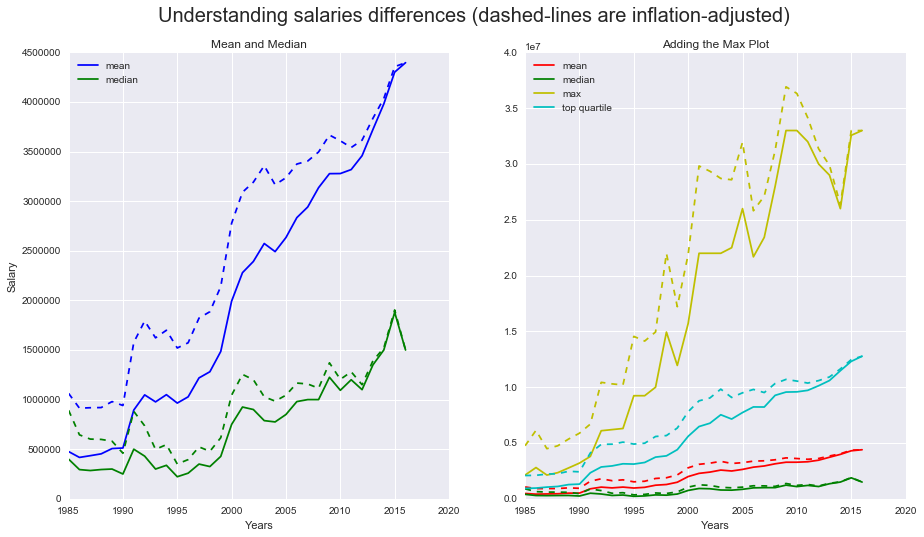

In [14]:
plt.figure(figsize=(15,8)) 
plt.suptitle('Understanding salaries differences (dashed-lines are inflation-adjusted)', fontsize=20)

plt.subplot(1, 2, 1)
plt.plot(mean_salary_pa, label='mean', c='blue')
plt.plot(mean_salary_pa_adj, ls='--',c='blue', label='')
plt.plot(median_salary_pa, label='median', c='green')
plt.plot(median_salary_pa_adj, label='', c='green', ls='--')

plt.legend(loc='upper left')
plt.xlabel('Years')
plt.ylabel('Salary')
plt.title('Mean and Median')

plt.subplot(1, 2, 2)
plt.plot(mean_salary_pa, label='mean', c='r')
plt.plot(mean_salary_pa_adj, label='', c='r', ls='--')
plt.plot(median_salary_pa, label='median', c='g')
plt.plot(median_salary_pa_adj, label='', c='g', ls='--')
plt.plot(max_salary_pa, label='max', c='y')
plt.plot(max_salary_pa_adj, label='', c='y', ls='--')
plt.plot(top_quartile_pa, label='top quartile', c='c')
plt.plot(top_quartile_pa_adj, label='', c='c', ls='--')
plt.legend(loc='upper left')
plt.xlabel('Years')
plt.title('Adding the Max Plot')

#### Histogram of salary

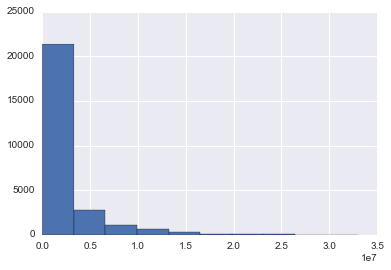

In [15]:
salaries.salary.hist()

#### First let's note that the data for the salaries is spanning from 1985 to 2016, unlike other datasets
- the inflation adjusted data does not change the trends so we will continue with the nominal data 
- the spread between mean an median increases at a fast rate 
- so we need a better understanding of the difference between average/median and maximum values. Since there are huge inequalities between players, what are the reasons:
    - skills?
    - college?
    - team?
    - but the first step would be to understand the origin of the maximum values

## Understanding the highest salaries

We shall look at the highest salaries per year and not overall because of salaries evolution, we would only get data in the latest years.

In [16]:
top_1pct_salaries_per_annum = salaries.groupby\
                               ('yearID', group_keys=False).apply\
                               (lambda g: g[g.salary>= g.salary.quantile(0.99)]).reset_index(drop=True)

In [17]:
top_1pct_salaries_per_annum.head()

,yearID,teamID,lgID,playerID,salary,CPI,salary_adj
0,1985,ATL,NL,murphda05,1625000,107.55,3.626334e+06
1,1985,NYA,AL,winfida01,1795704,107.55,4.007275e+06
2,1985,NYN,NL,cartega01,2028571,107.55,4.526939e+06
3,1985,NYN,NL,fostege01,1942857,107.55,4.335660e+06
4,1985,PHI,NL,schmimi01,2130300,107.55,4.753956e+06


### Who are these top paid players?

#### which teams do they belong to?

In [18]:
teams_top_salaries=[]
teams_no_top_salaries=[]

In [19]:
for team in salaries.teamID.unique():
    if team in top_1pct_salaries_per_annum.teamID.unique():
        teams_top_salaries.append(team)
    else:
        teams_no_top_salaries.append(team)

In [20]:
print "- Number of teams without top salaries (best 5% salaries) players: ",len(teams_no_top_salaries)
print "- Number of teams with top salaries players:", len(teams_top_salaries)

- Number of teams without top salaries (best 5% salaries) players:  12
- Number of teams with top salaries players: 34


In [21]:
print teams_top_salaries

['ATL', 'BAL', 'BOS', 'CAL', 'CHA', 'CHN', 'CIN', 'CLE', 'DET', 'HOU', 'KCA', 'LAN', 'MIN', 'ML4', 'NYA', 'NYN', 'OAK', 'PHI', 'PIT', 'SDN', 'SEA', 'SFN', 'SLN', 'TEX', 'TOR', 'COL', 'FLO', 'ANA', 'ARI', 'LAA', 'CHC', 'LAD', 'NYM', 'NYY']


In [22]:
# count the number of higly paid players per team over the whole period
top_1pct_salaries_per_annum.groupby('teamID')['playerID'].count().sort_values(ascending=False).head()

teamID
NYA    49
NYN    27
BOS    22
LAN    19
SFN    15
Name: playerID, dtype: int64

In [23]:
# count the number of higly paid players per team per year
top_1pct_salaries_per_annum.groupby(['teamID', 'yearID'])['playerID'].count().head()

teamID  yearID
ANA     2000      1
        2001      1
ARI     1999      1
        2000      1
        2001      1
Name: playerID, dtype: int64

##### Some team do indeed have more higly paid players 

### Why these teams have highly paid players? Do they win more on average?

#### Interesting dimensions to explore are:
- Rank: position in final standings
- W: Wins
- L: Losses
- DivWin: Division Winner (Y or N)
- WCWin: Wild Card Winner (Y or N)
- LgWin: League Champion(Y or N)
- WSWin: World Series Winner (Y or N)
- HR: Homeruns by batters
- SV: Saves
- E: Errors
- name: Team's full name

In [24]:
teams.head(2)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,NaN,NaN,N,NaN,401,1372,426,70,37,3,60,19.0,73.0,NaN,NaN,NaN,303,109,3.55,22,1,3,828,367,2,42,23,225,NaN,0.838,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,NaN,NaN,N,NaN,302,1196,323,52,21,10,60,22.0,69.0,NaN,NaN,NaN,241,77,2.76,25,0,1,753,308,6,28,22,218,NaN,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1


In [25]:
# Since we only have salaries data from 1985, we do not need the whole dataset so we slice the part of the dataframe
# we are interest into
teams_1985_2016 = teams[teams['yearID']>=1985]

In [26]:
teams_1985_2016.head(2)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
1917,1985,NL,ATL,ATL,W,5,162,81.0,66,96,N,NaN,N,N,632,5526,1359,213,28,126,553,849.0,72.0,52.0,NaN,NaN,781,678,4.19,9,9,29,4371,1512,134,642,776,159,197.0,0.976,Atlanta Braves,Atlanta-Fulton County Stadium,1350137.0,105,106,ATL,ATL,ATL
1918,1985,AL,BAL,BAL,E,4,161,81.0,83,78,N,NaN,N,N,818,5517,1451,234,22,214,604,908.0,69.0,43.0,NaN,NaN,764,694,4.38,32,6,33,4281,1480,160,568,793,115,168.0,0.980,Baltimore Orioles,Memorial Stadium,2132387.0,97,97,BAL,BAL,BAL


In [27]:
# create a new columns which maps whether the team has high payed players or not 

In [28]:
print teams_top_salaries
print teams_no_top_salaries

['ATL', 'BAL', 'BOS', 'CAL', 'CHA', 'CHN', 'CIN', 'CLE', 'DET', 'HOU', 'KCA', 'LAN', 'MIN', 'ML4', 'NYA', 'NYN', 'OAK', 'PHI', 'PIT', 'SDN', 'SEA', 'SFN', 'SLN', 'TEX', 'TOR', 'COL', 'FLO', 'ANA', 'ARI', 'LAA', 'CHC', 'LAD', 'NYM', 'NYY']
['MON', 'MIL', 'TBA', 'WAS', 'MIA', 'CHW', 'KCR', 'SDP', 'SFG', 'STL', 'TBR', 'WSN']


In [29]:
def add_column_bin_salaries(team):
    if team in teams_top_salaries:
        return 1
    elif team in teams_no_top_salaries:
        return 0
    else:
        return -1

In [65]:
#return a new column matching values from the function add_column_bin_salaries

teams_1985_2016['topSalary'] = teams_1985_2016['teamID'].apply(add_column_bin_salaries)

In [66]:
teams_1985_2016.tail(2)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,topSalary
2833,2016,AL,TOR,TOR,E,2,162,81.0,89,73,N,Y,N,N,759,5479,1358,276,18,221,632,1362.0,54.0,24.0,55.0,40.0,666,613,3.78,0,10,43,4378,1340,183,461,1314,88,144.0,0.986,Toronto Blue Jays,Rogers Centre,3392099.0,111,110,TOR,TOR,TOR,1
2834,2016,NL,WAS,WSN,E,1,162,81.0,95,67,Y,N,N,N,763,5490,1403,268,29,203,536,1252.0,121.0,39.0,64.0,63.0,612,570,3.51,1,12,46,4379,1272,155,468,1476,73,142.0,0.988,Washington Nationals,Nationals Park,2481938.0,100,98,WSN,MON,WAS,0


In [32]:
avg_wins_per_group = pd.DataFrame(teams_1985_2016.groupby(['yearID', 'topSalary'])['W'].mean()).reset_index()
avg_losses_per_group = pd.DataFrame(teams_1985_2016.groupby(['yearID', 'topSalary'])['L'].mean()).reset_index()

In [33]:
avg_losses_per_group.head()

,yearID,topSalary,L
0,1985,0,77.00
1,1985,1,80.96
2,1986,0,83.00
3,1986,1,80.76
4,1987,0,71.00


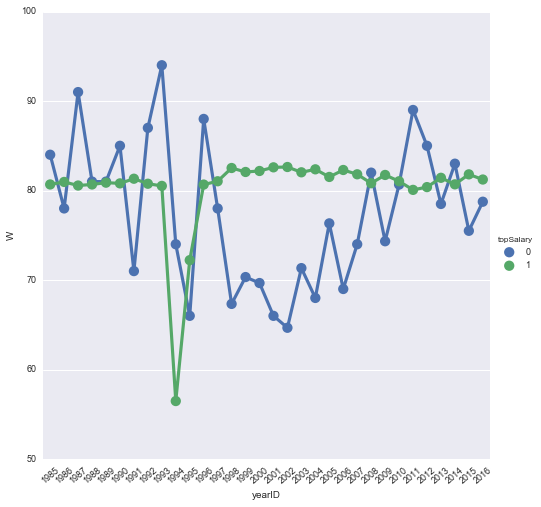

In [34]:
sns.set(font_scale=0.9)
f = sns.factorplot(x="yearID", y="W",data=avg_wins_per_group, hue='topSalary', size=7)
f.set_xticklabels(rotation=40)

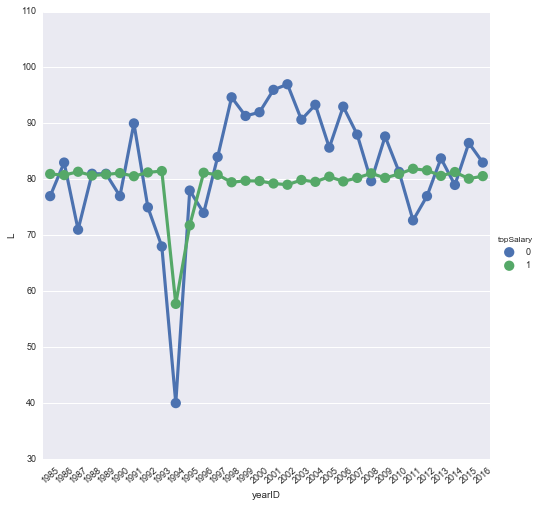

In [35]:
sns.set(font_scale=0.9)
f = sns.factorplot(x="yearID", y="L",data=avg_losses_per_group, hue='topSalary', size=7)
f.set_xticklabels(rotation=40)

- can see that something interesting happened in 1994:
    - actuall when searching into it, there was a player strike that ended the season abruptly (http://www.usatoday.com/story/sports/mlb/2014/08/11/1994-mlb-strike/13912279/) 
- teams with top salary player(s) tend to have steady performance in tearms of average wins and losses 
    - on average they win more
- teams without top salary player(s) have more volatile performances

#### - further it could be interesting to see if the players playing in teams with no top salaries moved to top salaries team the years where their teams performed well 

## Exploring the players attributes

###  Look at the most paid players (the top 1%) and looks into them, where they come from  and their statistics compared to average satistics so see if salaries are really justified.

In [36]:
top_1pct_salaries_per_annum.head()

,yearID,teamID,lgID,playerID,salary,CPI,salary_adj
0,1985,ATL,NL,murphda05,1625000,107.55,3.626334e+06
1,1985,NYA,AL,winfida01,1795704,107.55,4.007275e+06
2,1985,NYN,NL,cartega01,2028571,107.55,4.526939e+06
3,1985,NYN,NL,fostege01,1942857,107.55,4.335660e+06
4,1985,PHI,NL,schmimi01,2130300,107.55,4.753956e+06


In [52]:
print 'lenght batting dataset: ',len(batting)
print 'lenght pitching dataset: ', len(pitching)
print 'lenght fielding dataset: ', len(fielding)

lenght batting dataset:  102816
lenght pitching dataset:  44963
lenght fielding dataset:  136815


In [53]:
# so we need to check where our higly players are or if they are in several datasets we can create three columns to 
# check if player is battling, pitching or fielding 

In [172]:
# One player 'sabatc.01' is not in pitching, bating or fielding, where is he? is this an error? (we found that later
#but we moved it here to avoid rerunning the code)
import fnmatch
players = master.playerID.unique()
pattern = 'sabatc*01'
matching = fnmatch.filter(players, pattern)
print matching

['sabatcc01']


In [173]:
# So we need to replace this value in the salaries and top_1pct_salaries_per_annum dataframes <= to be done
salaries.replace('sabatc.01', 'sabatcc01', inplace=True)
top_1pct_salaries_per_annum.replace('sabatc.01', 'sabatcc01', inplace=True)

In [174]:
def pitcher(player):
    if player in pitching.playerID.unique():
        return 1
    else:
        return 0
def batter(player):
    if player in batting.playerID.unique():
        return 1
    else:
        return 0
def fielder(player):
    if player in fielding.playerID.unique():
        return 1
    else:
        return 0

In [175]:
top_1pct_salaries_per_annum['pitcher'] = top_1pct_salaries_per_annum['playerID'].apply(pitcher)
top_1pct_salaries_per_annum['batter'] = top_1pct_salaries_per_annum['playerID'].apply(batter)
top_1pct_salaries_per_annum['fielder'] = top_1pct_salaries_per_annum['playerID'].apply(fielder)

In [176]:
top_1pct_salaries_per_annum.head()

,yearID,teamID,lgID,playerID,salary,CPI,salary_adj,status,pitcher,batter,fielder
0,1985,ATL,NL,murphda05,1625000,107.55,3.626334e+06,NaN,0,1,1
1,1985,NYA,AL,winfida01,1795704,107.55,4.007275e+06,NaN,0,1,1
2,1985,NYN,NL,cartega01,2028571,107.55,4.526939e+06,NaN,0,1,1
3,1985,NYN,NL,fostege01,1942857,107.55,4.335660e+06,NaN,0,1,1
4,1985,PHI,NL,schmimi01,2130300,107.55,4.753956e+06,NaN,0,1,1


In [187]:
print top_1pct_salaries_per_annum['pitcher'].sum()
print top_1pct_salaries_per_annum['batter'].sum()
print top_1pct_salaries_per_annum['fielder'].sum()

85
290
290


So all the players are batters and fielders (hope that is how you say it), and only 84 are pitchers. Are they the highest earners?

In [191]:
mean_salary_pa_top1 = top_1pct_salaries_per_annum.groupby(['yearID', 'pitcher']).mean()['salary_adj']

In [193]:
mean_salary_pa_top1

yearID  pitcher
1985    0          4.250033e+06
        1          3.823457e+06
1986    0          4.609169e+06
        1          3.996475e+06
1987    0          4.317994e+06
1988    0          4.537472e+06
        1          4.201400e+06
1989    0          4.666031e+06
        1          4.905109e+06
1990    0          4.704021e+06
        1          4.776269e+06
1991    0          6.587577e+06
        1          6.453946e+06
1992    0          8.382300e+06
        1          8.657804e+06
1993    0          9.226586e+06
        1          9.564313e+06
1994    0          8.942303e+06
        1          9.146997e+06
1995    0          1.184563e+07
        1          1.142143e+07
1996    0          1.134098e+07
        1          1.021390e+07
1997    0          1.195623e+07
        1          1.255723e+07
1998    0          1.398087e+07
        1          1.336238e+07
1999    0          1.409819e+07
        1          1.487133e+07
2000    0          1.689440e+07
        1          1.831

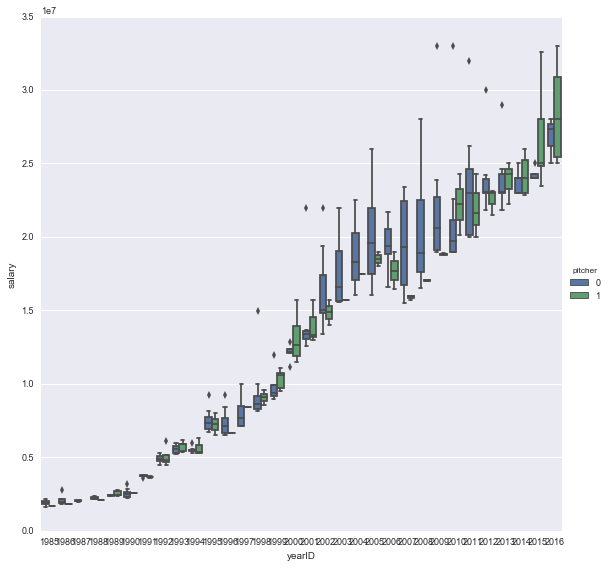

In [200]:
sns.factorplot(x='yearID', y='salary', kind='box', data=top_1pct_salaries_per_annum, hue='pitcher', size=8);